# Benckmarking Confidence Interval Methods for Skewed Data through Simulation

**Authors:** Xin (David) Zhao  
**Date:** May 2025  
**Project:** Interval Estimation Benckmark - Autoimmune Encephalitis Use Case

---

## 📝 Purpose & Overview

This notebook benchmarks three statistical methods for estimating confidence intervals (CIs) of the mean on simulated right-skewed, overdispersed data.

- **Context**: Hospital length of stay for autoimmune encephalitis is often skewed and highly variable.
- **Goal**: Evaluate coverage probability and interval width of:
  - t-distribution method
  - z-distribution method
  - Bootstrap percentile method
- **Approach**: Simulate data, apply methods, and compare performance across varying sample sizes and skewness.

---

The notebook focuses on comparing frequentist methods and does not include Bayesian credible intervals, as they follow a different philosophy and require a distinct interpretation.

## 🛠️ Environment & Dependencies

We start by importing necessary Python libraries for simulation, statistical calculations, and visualization.  
Setting a random seed ensures reproducibility of results.

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import scipy
import scipy.stats as stats
from scipy.stats import norm
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm

# Set visualization settings
sns.set_theme(style="whitegrid", palette="muted")
plt.rcParams['figure.figsize'] = (10, 6)

# Fix random seed for reproducibility
np.random.seed(42)

# Display package versions for reproducibility reference
import sys
print(f"Python version: {sys.version}")
print(f"Pandas version: {pd.__version__}")
print(f"Numpy version: {np.__version__}")
print(f"Scipy version: {scipy.__version__}")
print(f"Matplotlib version: {matplotlib.__version__}")
print(f"Seaborn version: {sns.__version__}")
print(f"TQDM version: {tqdm.__version__}")


Python version: 3.12.2 | packaged by conda-forge | (main, Feb 16 2024, 20:54:21) [Clang 16.0.6 ]
Pandas version: 2.2.3
Numpy version: 1.26.4
Scipy version: 1.13.1
Matplotlib version: 3.9.2
Seaborn version: 0.13.2
TQDM version: 4.66.4


To reproduce this environment:
1. Clone the repository
2. Install dependencies via:

pip install -r requirements.txt

3. Run the notebook with Python >= 3.12
   
The file `requirements.txt` has been generated with exact package versions.

## ⚙️ Simulation Configuration

In [66]:
# Simulation parameters
TRUE_POPULATION = 10000  # Total population size
TRUE_MEAN = 20          # True mean of length of stay
TRUE_SD_LIST = [5, 10, 20, 40]  # True SDs to simulate different dispersions
SAMPLE_SIZES = [10, 30, 100]    # Sample sizes to test
SKEW_LEVELS = [0.4, 0.8, 1.2]   # Sigma values in log-space to adjust skewness
N_REPS = 1000          # Number of simulation repetitions per scenario
BOOTSTRAP_N = 1000     # Bootstrap resampling iterations
CI_LEVEL = 0.95        # Confidence Interval level

print("Simulation configuration set.")

Simulation configuration set.


## ✅ Next Sections in This Notebook

1. Simulating Skewed Population Data
2. CI Methods Definitions (t, z, bootstrap)
3. Simulation Loop: Coverage & Width Benchmark
4. Results Visualization: Coverage Probability & Interval Width
5. Discussion & Takeaways

## Simulating Skewed Population Data

To mimic the real-world skewed distribution of hospital length of stay (LOS),  
we simulate data from a log-normal distribution using various standard deviations (SDs).

- True Mean: 20 days
- SDs tested: 5, 10, 20, 40 days

We compute sigma in log-space to correctly parameterize the log-normal distribution.


In [ ]:
# Log-space mean for lognormal distribution
mu = np.log(TRUE_MEAN)

# Initialize dictionaries to store sigma and simulated populations
sigma_dict = {}
true_population_dict = {}

# Simulate population data for each SD value
for sd in TRUE_SD_LIST:
    sigma_squared = np.log(1 + (sd**2) / (TRUE_MEAN**2))
    sigma = np.sqrt(sigma_squared)
    true_population = np.random.lognormal(mean=mu, sigma=sigma, size=TRUE_POPULATION)
    sigma_dict[str(sd)] = sigma    
    true_population_dict[str(sd)] = true_population

### Visualizing Simulated Populations

Histogram plots of the generated populations illustrate how increasing SD leads to stronger right-skewness.
The x-axis is limited to 0–400 for better visibility.

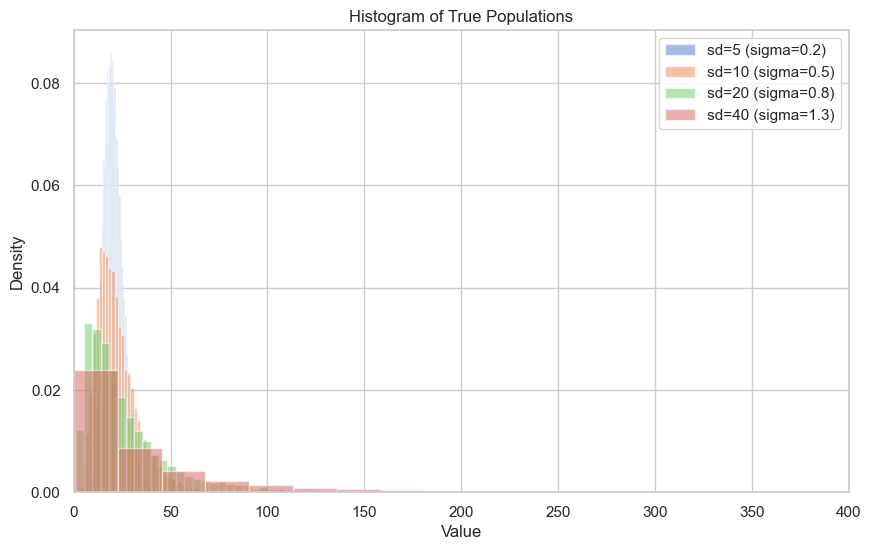

In [ ]:
# Plot histograms for each simulated population with varying SDs
for sd, true_population in true_population_dict.items():
    plt.hist(true_population, bins=100, density=True, alpha=0.5, label=f'sd={sd} (sigma={sigma_dict[sd]:.1f})')

plt.xlabel('Value')
plt.ylabel('Density')
plt.title('Histogram of True Populations')
plt.xlim(0, 400)    
plt.legend()
plt.show()

### Sampling from a log-normal distribution

Sample randomly from a log-normal distribution with the size of 50 patients. 

In [73]:
# np.random.seed(42)
sample_50 = np.random.choice(true_population_dict["5"], size=50, replace=False)

In [74]:
print(f"Sample mean: {np.mean(sample_50):.2f}, SD: {np.std(sample_50):.2f}")

Sample mean: 20.19, SD: 5.82


## CI Methods

### Method 1: t-distribution method

**Formula for t-distribution method:**
$$
CI = \bar{x} \pm t_{\alpha/2, n-1} \cdot \frac{s}{\sqrt{n}}
$$
Where:
- $\bar{x}$ is the sample mean
- $t_{\alpha/2, n-1}$ is the t-value for a two-tailed test with $\alpha$ level of significance and $n-1$ degrees of freedom
- $s$ is the sample standard deviation
- $n$ is the sample size

In [75]:
# t-distribution CI calculation

sample_n = len(sample_50)
sample_mean = np.mean(sample_50)
sample_sd = np.std(sample_50, ddof=1)
se = sample_sd / np.sqrt(sample_n)
t_crit = stats.t.ppf(0.975, df=sample_n-1) # percent point function 

ci_lower = sample_mean - t_crit * se
ci_upper = sample_mean + t_crit * se

# Print result
print(f"Sample mean = {sample_mean:.2f}")
print(f"95% t-distribution CI: ({ci_lower:.2f}, {ci_upper:.2f})")


Sample mean = 20.19
95% t-distribution CI: (18.51, 21.86)


## Method 2: z-distribution method
**Formula for z-distribution method:**
$$
CI = \bar{x} \pm z_{\alpha/2} \cdot \frac{\sigma}{\sqrt{n}}
$$
Where:
- $\bar{x}$ is the sample mean
- $z_{\alpha/2}$ is the z-value for a two-tailed test with $\alpha$ level of significance
- $\sigma$ is the population standard deviation
- $n$ is the sample size

In [77]:
# Z-distribution CI calculation
population_sd = np.std(true_population, ddof=0)
z_se = sample_sd / np.sqrt(sample_n)
z_crit = stats.norm.ppf(0.975) # percent point function\

z_ci_lower = sample_mean - z_crit * z_se
z_ci_upper = sample_mean + z_crit * z_se

# Print result
print(f"Sample mean = {sample_mean:.2f}")
print(f"95% z-distribution CI: ({z_ci_lower:.2f}, {z_ci_upper:.2f})")

Sample mean = 20.19
95% z-distribution CI: (18.56, 21.82)


## Method 3: Bootstrap method

Bootstrap resampling involves:
1. Draw many samples (with replacement) from the observed data.
2. Compute the sample mean for each resample. 
3. Take percentiles (e.g., 2.5th and 97.5th) of those means to form the bootstrap CI.

In [79]:
# Bootstrap 
# bootstrap_n = 1000
bootstrap_means = []

for _ in range(BOOTSTRAP_N):
    bootstrap_sample = np.random.choice(sample_50, size=50, replace=True)
    bootstrap_means.append(np.mean(bootstrap_sample))

ci_lower  = np.percentile(bootstrap_means, 2.5)
ci_upper = np.percentile(bootstrap_means, 97.5)

print(f"Bootstrap 95% CI for mean: ({ci_lower:.2f}, {ci_upper:.2f})") 

Bootstrap 95% CI for mean: (18.48, 21.72)


## Simulation Loops

### Confidence Interval Calculation Functions

Reusable functions to calculate 95% confidence intervals for the sample mean:
- t-distribution based CI
- z-distribution based CI
- Bootstrap percentile CI

In [ ]:
# Compute CI using t-distribution critical values
def ci_t(sample):
    n = len(sample)
    m = np.mean(sample)
    se = np.std(sample, ddof=1) / np.sqrt(n)
    t_crit = stats.t.ppf(0.975, df=n-1)
    return m - t_crit * se, m + t_crit * se

# Compute CI using z-distribution critical values
def ci_z(sample):
    n = len(sample)
    m = np.mean(sample)
    se = np.std(sample, ddof=1) / np.sqrt(n)
    z_crit = stats.norm.ppf(0.975)
    return m - z_crit * se, m + z_crit * se

# Compute CI using bootstrap resampling and percentile method
def ci_bootstrap(sample, n_bootstraps=BOOTSTRAP_N, ci=CI_LEVEL):
    n = len(sample)
    means = []

    for _ in range(n_bootstraps):
        resample = np.random.choice(sample, size=n, replace=True)
        means.append(np.mean(resample))

    alpha = 1 - ci
    lower = np.percentile(means, 100 * (alpha / 2))
    upper = np.percentile(means, 100 * (1 - alpha / 2))
    return lower, upper

### Simulation Loop for Coverage & Width

**Simulation Benchmark: Coverage & Width**

For each combination of sample size and skewness:
- Randomly sample data
- Calculate CIs using t, z, and bootstrap methods
- Record if CI contains the true mean and measure CI width

Repeat for 1,000 iterations per scenario.

In [ ]:
results = []
for skew in SKEW_LEVELS:
    mu = np.log(20)
    for n in SAMPLE_SIZES:
        # Generate true population with given skewness
        population = np.random.lognormal(mean=mu, sigma=skew, size=100000)
        true_mean = np.mean(population)

        for _ in tqdm.tqdm(range(N_REPS), desc=f"σ={skew}, n={n}"):
            # Sample n data points from population
            sample = np.random.choice(population, size=n, replace=False)

            # # Calculate CIs for each method
            t_low, t_high = ci_t(sample)
            z_low, z_high = ci_z(sample)
            b_low, b_high = ci_bootstrap(sample)

            results += [
                {"n": n, "skew": skew, "method": "t", "contains_mean": t_low <= true_mean <= t_high, "width": t_high - t_low},
                {"n": n, "skew": skew, "method": "z", "contains_mean": z_low <= true_mean <= z_high, "width": z_high - z_low},
                {"n": n, "skew": skew, "method": "bootstrap", "contains_mean": b_low <= true_mean <= b_high, "width": b_high - b_low}
            ]

# # Convert results to DataFrame and aggregate
df = pd.DataFrame(results)
summary = df.groupby(["n", "skew", "method"]).agg(
    coverage = ("contains_mean", "mean"),
    avg_width = ("width", "mean")
).reset_index()            

σ=1.2, n=100: 100%|██████████| 1000/1000 [00:11<00:00, 88.15it/s]


In [86]:
summary.head()

,n,skew,method,coverage,avg_width
0,10,0.4,bootstrap,0.886,10.021352
1,10,0.4,t,0.929,12.355860
2,10,0.4,z,0.904,10.705287
3,10,0.8,bootstrap,0.827,26.215983
4,10,0.8,t,0.875,32.897778


## Results Visualization

Aggregate simulation results to summarize:
- Coverage probability (proportion of CIs containing true mean)
- Average CI width

Visualized as bar plots to compare methods across sample sizes and skewness levels.

### Coverage probability

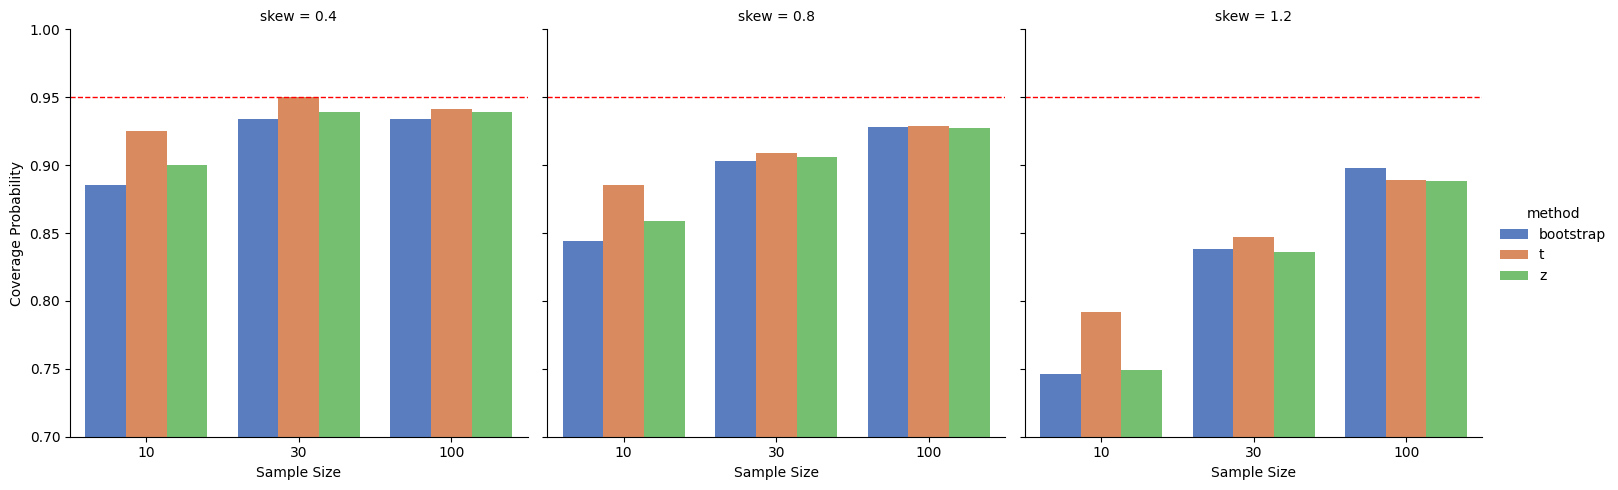

In [ ]:
# Plot coverage probabilities with target 95% reference line
barplot_coverage = sns.catplot(
    data=summary,
    x='n', 
    y='coverage', 
    hue='method',
    col='skew',
    kind='bar',
    palette='muted',
    errorbar=None)

# Adjust y-axis range, e.g., from 0 to 1.1
barplot_coverage.set(ylim=(0.7, 1.0))

# Add horizontal reference line at y=0.95
for ax in barplot_coverage.axes.flat:
    ax.axhline(0.95, ls='--', color='red', linewidth=1)

barplot_coverage.set_axis_labels("Sample Size", "Coverage Probability")

plt.show()

barplot_coverage.savefig("barplot_coverage.png", dpi=300, bbox_inches='tight')

### Interval width

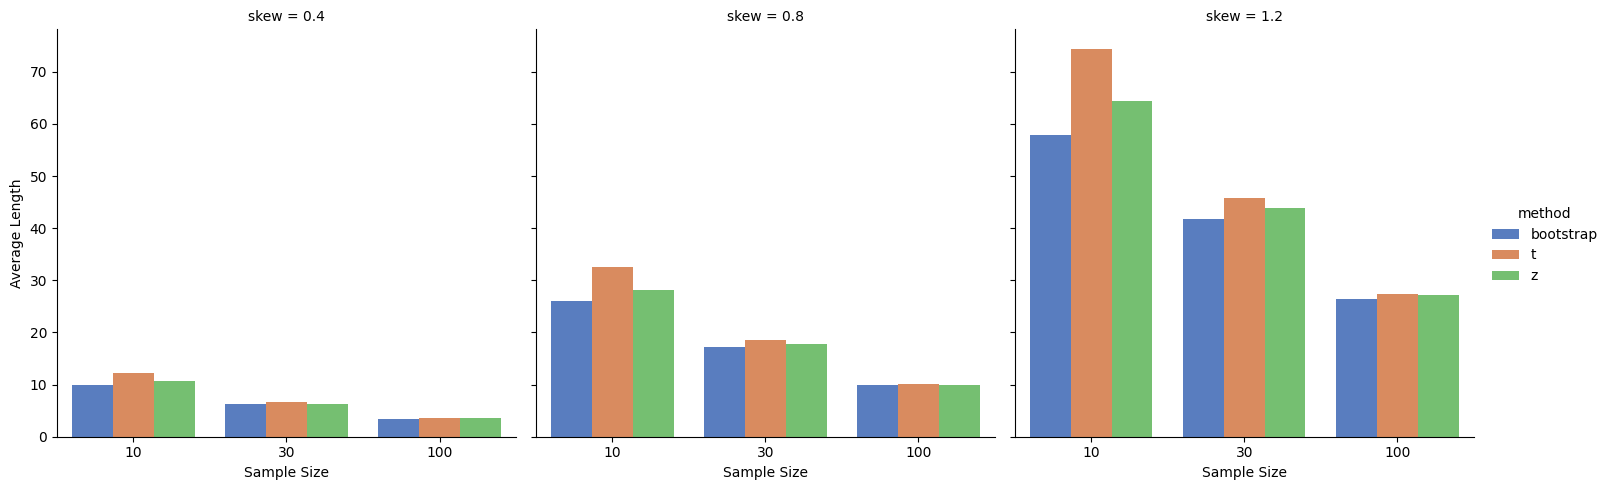

In [ ]:
# Plot average CI width
barplot_precision = sns.catplot(
    data=summary,
    x='n', 
    y='avg_width', 
    hue='method',
    col='skew',
    kind='bar',
    palette='muted',
    errorbar=None)

barplot_precision.set_axis_labels("Sample Size", "Average Length")

# Show plot
plt.show()

barplot_precision.savefig("barplot_precision.png", dpi=300, bbox_inches='tight')

## Discussion & Takeaways

- **Bootstrap** offers more precise (narrower) intervals but at the cost of coverage reliability, especially in small, skewed samples.
- **t-distribution** sacrifices precision (wider intervals) to maintain more accurate coverage.
- **z-distribution** is suboptimal when sample sizes are small and data is skewed, as it assumes normality which is not met.

## ✅ Notebook Summary

This notebook benchmarks confidence interval estimation methods on skewed data through simulation.  
It demonstrates practical trade-offs between accuracy (coverage) and precision (interval width).

For reproducibility:
- Random seeds are fixed.
- All parameters are configurable.
- Dependencies and versions are documented.